# Layoff Classification Prediction

Tech firms around the globe are fighting the economic slowdown. The slow consumer spending, higher interest rates by central banks and strong dollars overseas are hinting towards possible recession and tech firms have started laying employees off. This economic slowdown has made Meta recently fire 13% of its workforce, which amounts to more than 11,000 employees.
Tracking the tech layoffs reported on the following platforms:
- Bloomberg
- San Francisco Business Times
- TechCrunch
- The New York Times

The data availability is from when COVID-19 was declared as a pandemic i.e. 11 March 2020 to present (21 Apr 2025).
In this project we are predicting on which stage the company is based on other information provided.

## Loading the dataset

Here we are loading the dataset and imprting libraries required for the project.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
layoff_data = pd.read_csv('C:/Users/91701/Downloads/mydata/layoffs.csv')

In [3]:
layoff_data

,company,location,total_laid_off,date,percentage_laid_off,industry,source,stage,funds_raised,country,date_added
0,Airtime,New York City,25.0,6/4/2025,43%,Consumer,https://techcrunch.com/2025/06/04/its-layoff-s...,Series B,$33,United States,6/5/2025
1,Microsoft,Seattle,305.0,6/2/2025,3%,Other,https://www.geekwire.com/2025/new-filing-micro...,Post-IPO,$1,United States,6/5/2025
2,Hims & Hers,SF Bay Area,68.0,5/30/2025,4%,Healthcare,https://www.reuters.com/business/healthcare-ph...,Post-IPO,$1200,United States,6/5/2025
3,Business Insider,New York City,NaN,5/29/2025,20%,Media,https://www.adweek.com/media/business-insider-...,Acquired,$56,United States,6/1/2025
4,eBay,"Tel Aviv,Non-U.S.",200.0,5/28/2025,NaN,Retail,https://www.calcalistech.com/ctechnews/article...,Post-IPO,$1200,Israel,6/1/2025
...,...,...,...,...,...,...,...,...,...,...,...
4076,Service,Los Angeles,NaN,3/16/2020,100%,Travel,https://techcrunch.com/2020/03/16/travel-savin...,Seed,$5,United States,8/31/2020
4077,HopSkipDrive,Los Angeles,8.0,3/13/2020,10%,Transportation,https://layoffs.fyi/2020/04/02/hopskipdrive-la...,Unknown,$45,United States,4/3/2020
4078,Panda Squad,SF Bay Area,6.0,3/13/2020,75%,Consumer,https://twitter.com/danielsinger/status/123854...,Seed,$1,United States,4/17/2020
4079,Tamara Mellon,Los Angeles,20.0,3/12/2020,40%,Retail,https://layoffs.fyi/list/tamara-mellon/,Series C,$90,United States,3/31/2020


## Exploratory Data Analysis 

We see there are some null values so we will be replacing them in preprocessing section but we remove the values 'stage' column as this is our target variable.

In [4]:
layoff_data.isnull().sum()

company                   0
location                  1
total_laid_off         1418
date                      0
percentage_laid_off    1484
industry                  1
source                    3
stage                     7
funds_raised            447
country                   0
date_added                0
dtype: int64

In [5]:
layoff_data.duplicated().sum()

0

In [6]:
layoff_data = layoff_data.dropna(axis=0, subset=['stage']) #we drop rows where stage column is null

In [7]:
layoff_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4074 entries, 0 to 4080
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              4074 non-null   object 
 1   location             4073 non-null   object 
 2   total_laid_off       2660 non-null   float64
 3   date                 4074 non-null   object 
 4   percentage_laid_off  2591 non-null   object 
 5   industry             4073 non-null   object 
 6   source               4071 non-null   object 
 7   stage                4074 non-null   object 
 8   funds_raised         3632 non-null   object 
 9   country              4074 non-null   object 
 10  date_added           4074 non-null   object 
dtypes: float64(1), object(10)
memory usage: 381.9+ KB


Now we convert the data types of some columns like :
- 'date' from object to datetime 
- 'date_added' from object to datetime
- 'percentage_laid_off' from object to int
- 'funds_raised' from object to int

In [8]:
layoff_data['date'] = pd.to_datetime(layoff_data['date'])
layoff_data['date_added'] = pd.to_datetime(layoff_data['date_added'])

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\2528794521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['date'] = pd.to_datetime(layoff_data['date'])
C:\Users\91701\AppData\Local\Temp\ipykernel_18004\2528794521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['date_added'] = pd.to_datetime(layoff_data['date_added'])


In [9]:
layoff_data['percentage_laid_off'] = layoff_data['percentage_laid_off'].str.rstrip('%')  # remove '%' at the end
layoff_data['percentage_laid_off'] = pd.to_numeric(layoff_data['percentage_laid_off'], errors='coerce').astype('Int64')  # convert to integer, nullable type

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\3218360963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['percentage_laid_off'] = layoff_data['percentage_laid_off'].str.rstrip('%')  # remove '%' at the end
C:\Users\91701\AppData\Local\Temp\ipykernel_18004\3218360963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['percentage_laid_off'] = pd.to_numeric(layoff_data['percentage_laid_off'], errors='coerce').astype('Int64')  # convert to integer, nullable type


In [10]:
layoff_data['funds_raised'] = layoff_data['funds_raised'].str.lstrip('$')  #remove $ at the begining
layoff_data['funds_raised'] = pd.to_numeric(layoff_data['funds_raised'], errors='coerce').astype('Int64')  # convert to integer, nullable type

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\3310679545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['funds_raised'] = layoff_data['funds_raised'].str.lstrip('$')  #remove $ at the begining
C:\Users\91701\AppData\Local\Temp\ipykernel_18004\3310679545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['funds_raised'] = pd.to_numeric(layoff_data['funds_raised'], errors='coerce').astype('Int64')  # convert to integer, nullable type


In [11]:
layoff_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4074 entries, 0 to 4080
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              4074 non-null   object        
 1   location             4073 non-null   object        
 2   total_laid_off       2660 non-null   float64       
 3   date                 4074 non-null   datetime64[ns]
 4   percentage_laid_off  2591 non-null   Int64         
 5   industry             4073 non-null   object        
 6   source               4071 non-null   object        
 7   stage                4074 non-null   object        
 8   funds_raised         3632 non-null   Int64         
 9   country              4074 non-null   object        
 10  date_added           4074 non-null   datetime64[ns]
dtypes: Int64(2), datetime64[ns](2), float64(1), object(6)
memory usage: 389.9+ KB


In [12]:
layoff_data['year'] = layoff_data['date'].dt.year #extracting year from the date as it will be used for analysing data

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\1654140263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['year'] = layoff_data['date'].dt.year #extracting year from the date as it will be used for analysing data


In [13]:
layoff_data['country'].value_counts() # calculating counts of each value in 'country' column 

country
United States     2647
India              298
Canada             156
United Kingdom     133
Israel             119
                  ... 
Saudi Arabia         1
Malta                1
Cyprus               1
UAE                  1
Myanmar              1
Name: count, Length: 66, dtype: int64

In [14]:
layoff_data['industry'].value_counts() # calculating counts of each value in 'industry' column 

industry
Finance           491
Retail            328
Healthcare        318
Other             261
Transportation    252
Consumer          244
Food              237
Marketing         203
Real Estate       161
Education         156
Media             151
Crypto            151
Security          139
Data              130
Travel            105
HR                102
Infrastructure     76
Logistics          71
Hardware           65
Sales              62
Support            60
Recruiting         55
Product            52
Energy             46
Fitness            43
Manufacturing      25
Construction       25
Aerospace          24
AI                 20
Legal              20
Name: count, dtype: int64

In [15]:
layoff_data['stage'].value_counts() # calculating counts of each value in 'stage' column 

stage
Post-IPO          916
Unknown           691
Series B          462
Series C          427
Acquired          365
Series D          342
Series A          263
Series E          188
Seed              132
Series F          110
Private Equity     71
Series H           35
Subsidiary         27
Series G           26
Series J           10
Series I            9
Name: count, dtype: int64

In [16]:
layoff_data['company'].value_counts() # calculating counts of each value in 'company' column 

company
Amazon               14
Google               14
Microsoft            13
Rivian                8
Expedia               8
                     ..
1K Kirana             1
Amplitude             1
Avocargo              1
Absolute Software     1
Tamara Mellon         1
Name: count, Length: 2794, dtype: int64

In [17]:
layoff_data.describe()

,total_laid_off,date,percentage_laid_off,funds_raised,date_added,year
count,2660.000000,4074,2591.0,3632.0,4074,4074.000000
mean,278.850376,2022-11-22 22:11:50.456553728,29.253184,810.818007,2022-12-02 22:27:44.801178368,2022.440599
min,3.000000,2020-03-11 00:00:00,0.0,0.0,2020-03-28 00:00:00,2020.000000
25%,40.000000,2022-07-01 00:00:00,10.0,52.0,2022-07-11 06:00:00,2022.000000
50%,85.000000,2023-01-18 00:00:00,17.0,169.0,2023-01-21 00:00:00,2023.000000
75%,200.000000,2023-09-21 00:00:00,33.0,478.25,2023-10-04 00:00:00,2023.000000
max,22000.000000,2025-06-04 00:00:00,100.0,121900.0,2025-06-05 00:00:00,2025.000000
std,961.878216,NaN,30.141173,4595.661723,NaN,1.319380


<Axes: xlabel='total_laid_off', ylabel='Count'>

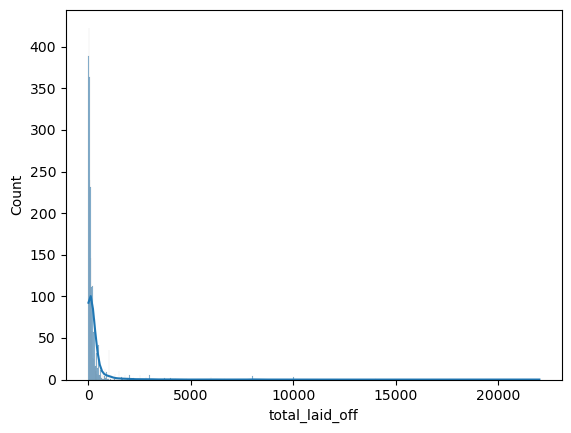

In [18]:
sns.histplot(data=layoff_data, x="total_laid_off", kde=True)

Above we see a graph for total_laid_off where we see it is a very skewed data as less number of people were laid off more frequently as compared to large number of people being laid off at one time.
We applied log scale to the above data so that graph is more clear.

<Axes: xlabel='total_laid_off', ylabel='Count'>

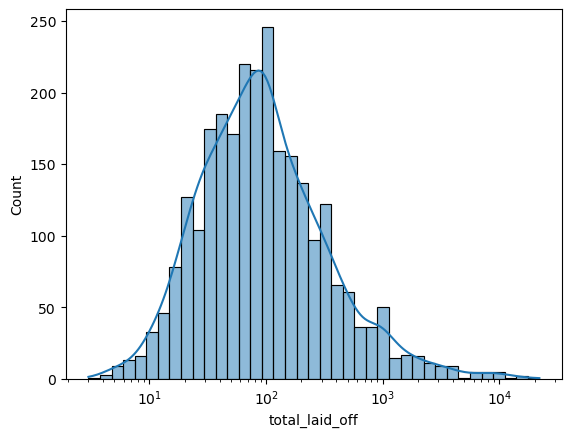

In [19]:
sns.histplot(data=layoff_data, x="total_laid_off",log_scale=True, kde=True)

Now we make a graph of percentage_laid_off which is the percentage people laid off  of the total number of people in the company.

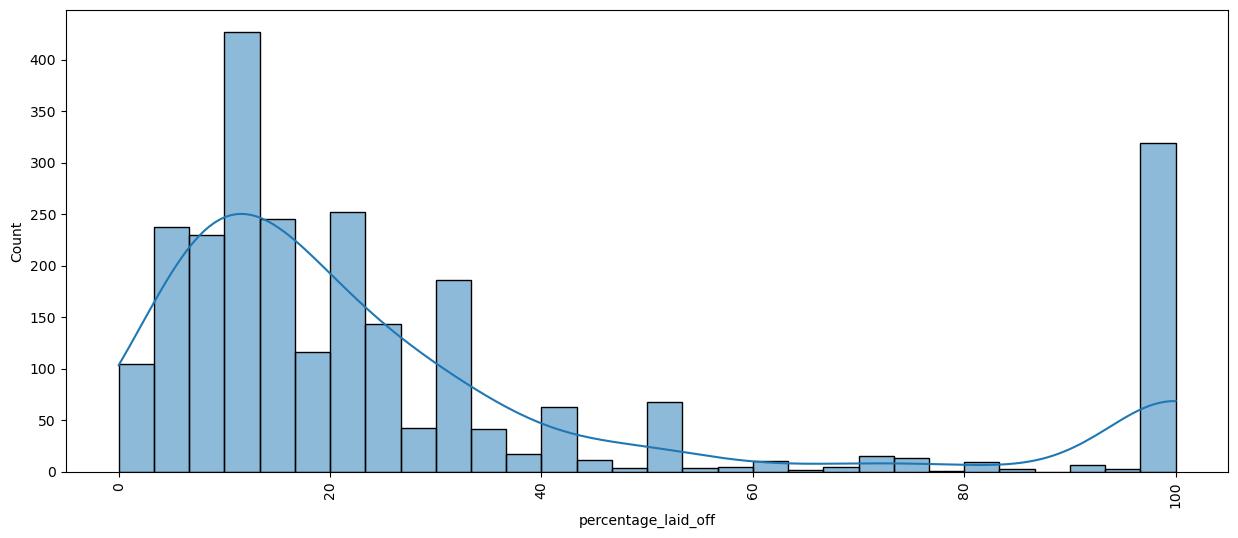

In [20]:
ax = sns.histplot(data=layoff_data, x="percentage_laid_off", kde=True)
ax.tick_params(axis='x', rotation=90)
ax.figure.set_size_inches(15, 6)
plt.show()

Now we make the boxplot to figure out the outliers in the total_laid_off categoriesed by 'stage'. As we claearly see there are some outliers mostly in Post-IPO.

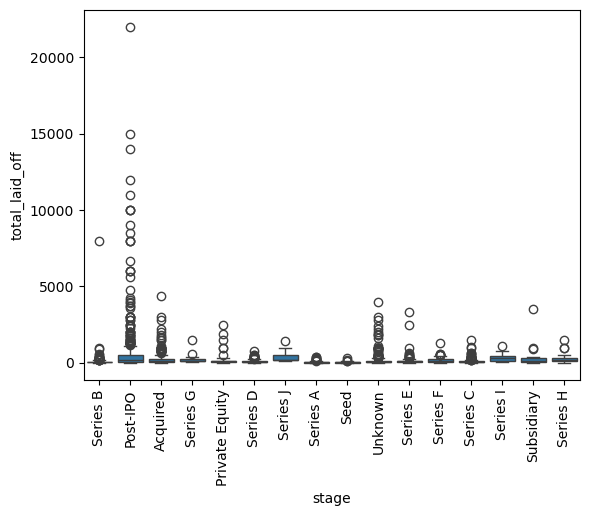

In [21]:
ax = sns.boxplot(x="stage", y="total_laid_off", data = layoff_data)
ax.tick_params(axis='x', rotation=90)

Now we make bar graph of total_laid_off for every year first one is total sum for every year and the second one is for average of the year.

<Axes: xlabel='year', ylabel='total_laid_off'>

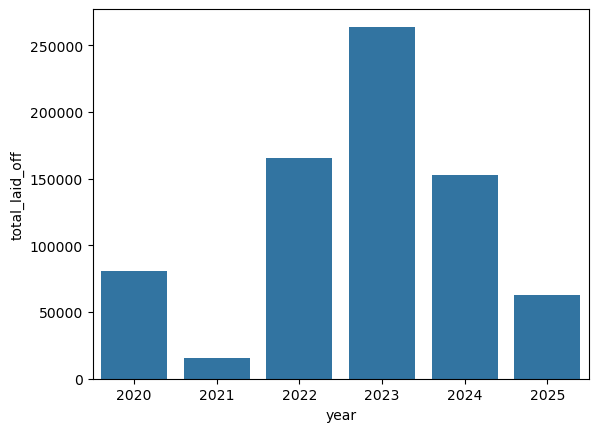

In [22]:
sns.barplot(layoff_data, x="year", y="total_laid_off", estimator="sum", errorbar=None)

<Axes: xlabel='year', ylabel='total_laid_off'>

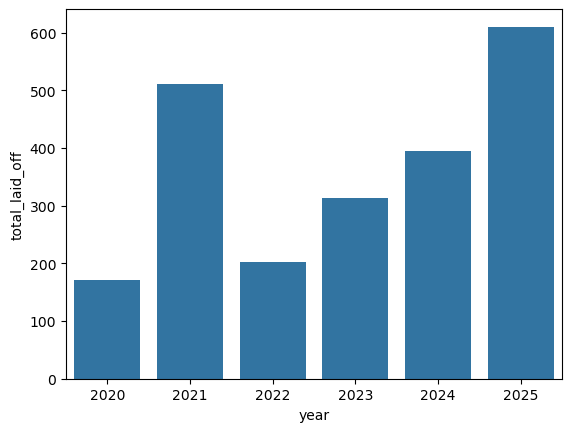

In [23]:
sns.barplot(layoff_data, x="year", y="total_laid_off", errorbar=None)

## Preprocessing



### Treating Null Values 

We will now treat null values in each column one by one starting with 'location', here we first find the row where 'location' is null we find the 'country' for the row and then corresponding to that country we find most common location and now we replace the null value with this most common value

In [24]:
print(layoff_data[layoff_data['location'].isnull()])

          company location  total_laid_off       date  percentage_laid_off  \
971  Product Hunt      NaN             NaN 2023-10-09                   60   

     industry                                             source     stage  \
971  Consumer  https://techcrunch.com/2023/10/19/product-hunt...  Acquired   

     funds_raised        country date_added  year  
971          <NA>  United States 2023-10-15  2023  


In [25]:
mydf = layoff_data[layoff_data['country'] == 'United States']

In [26]:
mydf['location'].value_counts()

location
SF Bay Area      1016
New York City     410
Boston            179
Seattle           169
Los Angeles       153
                 ... 
Memphis             1
Jersey City         1
Fort Collins        1
Providence          1
New Orleans         1
Name: count, Length: 115, dtype: int64

In [27]:
layoff_data['location'] = layoff_data['location'].fillna('SF Bay Area')

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\790143322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['location'] = layoff_data['location'].fillna('SF Bay Area')


Now for 'industry' column null value we replace it with most common value

In [28]:
print(layoff_data[layoff_data['industry'].isnull()])

       company     location  total_laid_off       date  percentage_laid_off  \
1013  Appsmith  SF Bay Area            35.0 2023-09-22                   25   

     industry                                             source     stage  \
1013      NaN  https://inc42.com/buzz/exclusive-insight-partn...  Series B   

      funds_raised        country date_added  year  
1013            51  United States 2023-09-24  2023  


In [29]:
layoff_data['industry'] = layoff_data['industry'].fillna('Finance')

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\1711454510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['industry'] = layoff_data['industry'].fillna('Finance')


For 'total_laid_off', 'percentage_laid_off', 'funds_raised' we use Random Imputation to replace null values and create new columns 'totallaidoff_random' ,'percentlaid_random' ,'fundraised_random'. <br> Also we plot kde plots of these columns to see if the original columns overlap with new ones(the more the overlap the more accurate is the method to replace null values)

In [30]:
layoff_data["totallaidoff_random"]=layoff_data["total_laid_off"]
random_sample = layoff_data["total_laid_off"].dropna().sample(layoff_data["total_laid_off"].isnull().sum(),random_state=0)
random_sample.index = layoff_data[layoff_data["total_laid_off"].isnull()].index
layoff_data.loc[layoff_data["total_laid_off"].isnull(), 'totallaidoff_random']=random_sample

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\2896077908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data["totallaidoff_random"]=layoff_data["total_laid_off"]


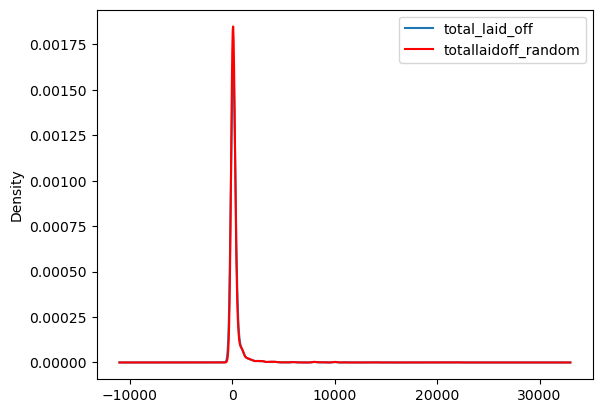

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
layoff_data['total_laid_off'].plot(kind='kde', ax=ax)
layoff_data['totallaidoff_random'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [32]:
layoff_data["percentlaid_random"]=layoff_data["percentage_laid_off"]
random_sample = layoff_data["percentage_laid_off"].dropna().sample(layoff_data["percentage_laid_off"].isnull().sum(),random_state=0)
random_sample.index = layoff_data[layoff_data["percentage_laid_off"].isnull()].index
layoff_data.loc[layoff_data["percentage_laid_off"].isnull(), 'percentlaid_random']=random_sample

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\2062168346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data["percentlaid_random"]=layoff_data["percentage_laid_off"]


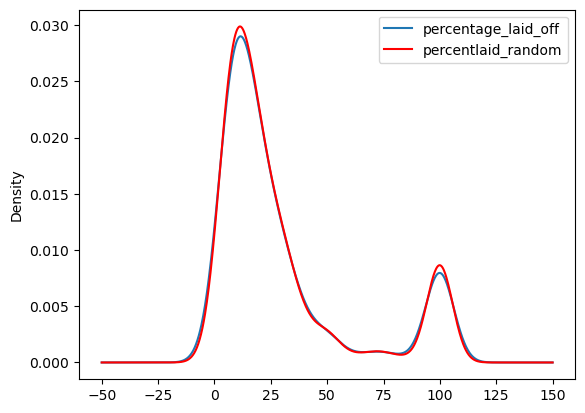

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
layoff_data['percentage_laid_off'].plot(kind='kde', ax=ax)
layoff_data['percentlaid_random'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [34]:
layoff_data["fundraised_random"]=layoff_data["funds_raised"]
random_sample = layoff_data["funds_raised"].dropna().sample(layoff_data["funds_raised"].isnull().sum(),random_state=0)
random_sample.index = layoff_data[layoff_data["funds_raised"].isnull()].index
layoff_data.loc[layoff_data["funds_raised"].isnull(), 'fundraised_random']=random_sample

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\3470195703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data["fundraised_random"]=layoff_data["funds_raised"]


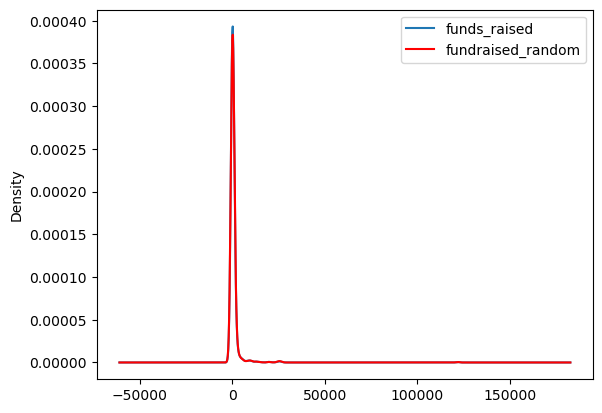

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
layoff_data['funds_raised'].plot(kind='kde', ax=ax)
layoff_data['fundraised_random'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [36]:
layoff_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4074 entries, 0 to 4080
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              4074 non-null   object        
 1   location             4074 non-null   object        
 2   total_laid_off       2660 non-null   float64       
 3   date                 4074 non-null   datetime64[ns]
 4   percentage_laid_off  2591 non-null   Int64         
 5   industry             4074 non-null   object        
 6   source               4071 non-null   object        
 7   stage                4074 non-null   object        
 8   funds_raised         3632 non-null   Int64         
 9   country              4074 non-null   object        
 10  date_added           4074 non-null   datetime64[ns]
 11  year                 4074 non-null   int32         
 12  totallaidoff_random  4074 non-null   float64       
 13  percentlaid_random   4074 non-null   I

### Categorical Columns

Here we encode all the categorical columns i.e. 'company', 'location', 'industry', 'country', 'stage' into numerical values 

In [37]:
encoder = LabelEncoder()
layoff_data['company'] = encoder.fit_transform(layoff_data['company'])
layoff_data['location'] = encoder.fit_transform(layoff_data['location'])
layoff_data['industry'] = encoder.fit_transform(layoff_data['industry'])
layoff_data['country'] = encoder.fit_transform(layoff_data['country'])
layoff_data['stage'] = encoder.fit_transform(layoff_data['stage'])

C:\Users\91701\AppData\Local\Temp\ipykernel_18004\483741096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['company'] = encoder.fit_transform(layoff_data['company'])
C:\Users\91701\AppData\Local\Temp\ipykernel_18004\483741096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoff_data['location'] = encoder.fit_transform(layoff_data['location'])
C:\Users\91701\AppData\Local\Temp\ipykernel_18004\483741096.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

We drop the 'source' column as it is not affecting our target column so we will not take this into our features.<br> Though there are outliers in our columns but we will not be removing our outliers as for this problem statement the outliers may be important for our predictions.

We divide the data into X and y. We also convert all X columns into float as all the columns have different data types. 

In [38]:
X = layoff_data[['company', 'location', 'industry', 'country', 'year', 'totallaidoff_random', 'percentlaid_random', 'fundraised_random']]
y = layoff_data['stage']
X = X.astype(float)

### Imbalanced Data 

We use SMOTENC to handle imbalanced data(as we have seen earlier target variable 'stage' is imbalanced) because we have categorical variables as well in our data.

In [39]:
categorical_cols = [0, 1, 2, 3] # index of company, location, etc.
smote_nc = SMOTENC(categorical_features=categorical_cols, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,train_size=0.7)

## Model Implementation & Evaluation

- We use AdaBoostClassifier and RandomForestClassifier to predict the 'stage' variable.
- AdaBoost gives us just an accuracy of 40% and RandomForest gives us 80% accuracy. Hence we suggest using RandomForest algorithm for this problem statement.
- We have predicted the best parameters for both algorithms and used accuracy score and classification report for evaluating the algorithms.

In [41]:
algo = AdaBoostClassifier()
grid={'n_estimators':[10, 50, 100, 500], 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0], 'algorithm':['SAMME']}
cv=KFold(n_splits=5,random_state=None,shuffle=False)
clf=GridSearchCV(algo,grid,cv=cv,scoring='accuracy')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
print(classification_report(y_test, y_pred))

Best: 0.333268 using {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.10      0.04      0.06       273
           1       0.24      0.16      0.19       297
           2       0.16      0.23      0.18       257
           3       0.36      0.61      0.45       283
           4       0.19      0.47      0.27       266
           5       0.20      0.07      0.10       267
           6       0.22      0.14      0.17       259
           7       0.26      0.13      0.17       279
           8       0.22      0.30      0.25       265
           9       0.31      0.38      0.34       298
          10       0.38      0.32      0.35       261
          11       0.43      0.67      0.53       277
          12       0.77      0.81      0.79       276
          13       0.97      0.88      0.92       264
          14       0.50      0.32      0.39       288
          15       0.18      0.06      0.09     

In [42]:
algo = RandomForestClassifier()
grid={'n_estimators': [50,100,500], 'criterion' : ['gini', 'entropy']}
cv=KFold(n_splits=5,random_state=None,shuffle=False)
clf=GridSearchCV(algo,grid,cv=cv,scoring='accuracy')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Best: 0.791012 using {'criterion': 'gini', 'n_estimators': 500}
[[176  10   6   7  22  15  12   6   2   2   3   0   0   0   3   9]
 [ 21 167   5   7   9  11  13  10  21   9   3   2   0   1   7  11]
 [  2   4 232   2   2   2   3   2   4   2   0   0   0   0   1   1]
 [  0   3   0 266   7   4   1   0   0   1   0   0   0   0   0   1]
 [  4   0   2  12 223   9   7   2   2   3   0   0   0   0   1   1]
 [  7  12   3   4  29 170  19   4   6   2   0   1   0   0   2   8]
 [  8   8   3   0   5  24 178   8   8   4   0   0   0   0   2  11]
 [  3  15   5   0   3   8  21 191  20   7   0   0   0   0   4   2]
 [  1   9   0   0   0   2   4   8 225   3   0   1   0   0   3   9]
 [  0   6   0   0   0   0   6   7   9 266   1   2   0   0   1   0]
 [  0   1   0   0   0   0   0   0   0   0 259   0   0   0   0   1]
 [  0   1   0   0   0   1   0   0   0   0   0 275   0   0   0   0]
 [  0   1   0   0   0   0   0   0   1   0   0   0 274   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 264   0   0